Start by importing a load of stuff

Add to this later if need more packages

In [2]:
import sympy as sym
sym.init_printing()

import numpy as np
from math import pi
import math

import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
import scipy.optimize
import scipy.integrate

import scipy.constants as const

#import qutip

from matplotlib.colors import Normalize as Norm

%load_ext cython
%matplotlib notebook

In [3]:
#define some s pre/post operators
#used for defining superoperators like L in matrix form

def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)

def spost(m):
    return TensorProduct(m.T, sym.eye(m.shape[0]))

def collapse(c):
    tmp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c))-spre(tmp)-spost(tmp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13

In [4]:
#define symbols that are used for the symbolic stuff
delta2,delta3=sym.symbols('delta_2 delta_3', real=True)
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu=sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False)
omegao, omegam=sym.symbols('Omega_o Omega_mu', real=True, negative=False)
rho11, rho12, rho13, rho21, rho22, rho23, rho31, rho32, rho33=sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33')

a= sym.symbols('a')
ar,ai=sym.symbols('a_r a_i', real=True)
g=sym.symbols('g',real=True, negative=False)
lam=sym.symbols('lambda')

In [5]:
#define the Hamiltonian for the system
#might add to this if we want to include more stuff
H=omegam*s21+omegao*s32+ g*a*s31
H=H+Dagger(H)
H=H+delta2*s22+delta3*s33

H_no_a=H[:,:]
H_no_a[0,2]=0
H_no_a[2,0]=0
H_no_a

H_o=H_no_a[:,:]
H_o[0,1]=0
H_o[1,0]=0

H_mu=H_no_a[:,:]
H_mu[2,1]=0
H_mu[1,2]=0


H, H_no_a, H_o, H_mu

⎛⎡            _⎤                                             ⎞
⎜⎢ 0   Ωₘᵤ  g⋅a⎥  ⎡ 0   Ωₘᵤ  0 ⎤  ⎡0  0   0 ⎤  ⎡ 0   Ωₘᵤ  0 ⎤⎟
⎜⎢             ⎥  ⎢            ⎥  ⎢         ⎥  ⎢            ⎥⎟
⎜⎢Ωₘᵤ  δ₂   Ωₒ ⎥, ⎢Ωₘᵤ  δ₂   Ωₒ⎥, ⎢0  δ₂  Ωₒ⎥, ⎢Ωₘᵤ  δ₂   0 ⎥⎟
⎜⎢             ⎥  ⎢            ⎥  ⎢         ⎥  ⎢            ⎥⎟
⎝⎣a⋅g  Ωₒ   δ₃ ⎦  ⎣ 0   Ωₒ   δ₃⎦  ⎣0  Ωₒ  δ₃⎦  ⎣ 0    0   δ₃⎦⎠

In [6]:
H.subs({a:0}).eige

⎡ 0   Ωₘᵤ  0 ⎤
⎢            ⎥
⎢Ωₘᵤ  δ₂   Ωₒ⎥
⎢            ⎥
⎣ 0   Ωₒ   δ₃⎦

In [6]:
#define the Liovillian for the system in Matrix form
#We change the first row to impose the normalisation condition
LH=-I*spre(H)+I*spost(H)
L21 = gammamu*(nbath+1)*collapse(s12)
L12 = gammamu*nbath*collapse(s21)
L32 = gamma23*collapse(s23)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L = LH + L21 + L12 + L32 + L31 + L22 + L33

L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
L.row_del(1)

In [7]:
#define the density matrix in square and row form
#the row form is so the Liovillian in matrix form can be acted on it
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T #because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T 
rhoflat = rhoflat[:]

In [8]:
#CtoR takes the complex, Hermitian Liovillian and transforms to a real, non hermitian version
CtoR = Matrix([[2,0,0,0,0,0,0,0,0],
               [0,0,0,0,2,0,0,0,0],
               [0,0,0,0,0,0,0,0,2],
               [0,1,0,1,0,0,0,0,0],
               [0,I,0,-I,0,0,0,0,0],
               [0,0,1,0,0,0,1,0,0],
               [0,0,I,0,0,0,-I,0,0],
               [0,0,0,0,0,1,0,1,0],
               [0,0,0,0,0,I,0,-I,0]
              ])
CtoR=CtoR/2

In [9]:
#make lambda functions for the Liovillian so it can be used for numerics

Lreal = sym.simplify(CtoR*L*CtoR.inv())
Lreal = Lreal.subs(a,ar+I*ai)
Lreal


Lfunc = sym.lambdify((a,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),L)

Lrealfunc = sym.lambdify((ar,ai,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),Lreal)

In [10]:
#some default parameters
p = {}
#p['a'] = 0
#p['delta2'] = 0.
#p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 1e3
p['omegam'] = 1e7
p['g'] = 0.
#p['del2min']=-40e6
#p['del2max']= 40e6
#p['del3min']=-40e6
#p['del3max']= 40e6
#p['ndelta2']=50
#p['ndelta3']=50

#p['m2']=0 
#p['sd2']=20e6/2.355 #2.355 is to turn FWHM into standard deviation
#p['m3']=0
#p['sd3']=300e6/2.355

In [109]:
def dressed_states(delta3vals,p):
    omegamval=p['omegam']
    omegaoval=p['omegao']
    #delta3vals=np.linspace(p['del3min'],p['del3max'],p['ndelta3'])
    H_disc=sym.discriminant(sym.det(H_no_a-lam*sym.eye(3)),lam)
    H_disc_fun=sym.lambdify((delta2,delta3, omegam, omegao), H_disc)
    H_disc_diff=sym.diff(H_disc,delta2)
    H_disc_diff_fun=sym.lambdify((delta2,delta3, omegam, omegao), H_disc_diff)
    delta2_ds_vals=np.zeros(np.size(delta3vals))
    delta3min=np.min(delta3vals)
    delta3max=np.max(delta3vals)
    for ii in range(len(delta3vals)):
        try:
            delta2_ds_vals[ii]=scipy.optimize.brentq(H_disc_diff_fun,-(-omegamval**2/delta3vals[ii]+delta3vals[ii]), omegaoval**2/delta3vals[ii],
                                                 args=(delta3vals[ii], omegamval, omegaoval))
            #if np.abs(H_disc_fun(delta2_ds_vals[ii],delta3vals[ii], omegamval, omegaoval))>1e36:
             #   delta2_ds_vals[ii]=np.nan
        except (ValueError, RuntimeError) as e:
            try:
                delta2_ds_vals[ii]=scipy.optimize.brentq(H_disc_diff_fun,(-omegamval**2/delta3vals[ii]+delta3vals[ii]), -omegaoval**2/delta3vals[ii],
                                                 args=(delta3vals[ii], omegamval, omegaoval))
            except (ValueError, RuntimeError) as e:
                delta2_ds_vals[ii]=np.nan
    return delta2_ds_vals

In [12]:
def dressed_states_single(delta3val,p):
    
    omegamval=p['omegam']
    omegaoval=p['omegao']
    H_disc=sym.discriminant(sym.det(H_no_a-lam*sym.eye(3)),lam)
    H_disc_fun=sym.lambdify((delta2,delta3, omegam, omegao), H_disc)
    H_disc_diff=sym.diff(H_disc,delta2)
    H_disc_diff_fun=sym.lambdify((delta2,delta3, omegam, omegao), H_disc_diff)
    #delta2_ds_vals=np.zeros(len(delta3vals))
    #delta3min=np.min(delta3vals)
    #delta3max=np.max(delta3vals)
    try:
        delta2_ds_val=scipy.optimize.brentq(H_disc_diff_fun,-(-omegamval**2/delta3val+delta3val), omegaoval**2/delta3val,
                                                 args=(delta3val, omegamval, omegaoval))
            #if np.abs(H_disc_fun(delta2_ds_vals[ii],delta3vals[ii], omegamval, omegaoval))>1e36:
             #   delta2_ds_vals[ii]=np.nan
    except (ValueError, RuntimeError,ZeroDivisionError) as e:
        try:
            delta2_ds_val=scipy.optimize.brentq(H_disc_diff_fun,(-omegamval**2/delta3val+delta3val), -omegaoval**2/delta3val,
                                                 args=(delta3val, omegamval, omegaoval))
        except (ValueError, RuntimeError,ZeroDivisionError) as e:
                delta2_ds_val=np.nan
    return delta2_ds_val

In [13]:
def steady_rho_lots_of_args(delta2val,delta3val,aval,p):
    #aval=p['a']
    #delta2val=p['delta2']
    #delta3val=p['delta3']
    #a_r=np.real(a)
    #a_i=np.imag(a)
    L_mat=Lfunc(aval, delta2val,delta3val,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['omegao'],p['omegam'],p['g'])
    rho = np.linalg.solve(L_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return np.reshape(rho,(3,3),order='F')
def steady_rho_lots_of_args_inds(ind1,ind2,delta2vals, delta3vals,aval, p):
    ndelta2=len(delta2vals)
    ndelta3=len(delta3vals)
    coh_vals=np.zeros((ndelta2,ndelta3), dtype=np.complex_)
    for ii in range(ndelta2):
        for jj in range(ndelta3):
            coh_vals[ii,jj]=steady_rho_lots_of_args(delta2vals[ii],delta3vals[jj],aval,p)[ind1-1,ind2-1]
    return coh_vals


In [14]:
def integrate1d_peaks(func,x,ylims, peak_func,aval,p):
    peak_yval=peak_func(x)
    
    if (np.isnan(peak_yval) or peak_yval>ylims[1] or peak_yval<ylims[0]):
        funcval=scipy.integrate.quad(func, ylims[0], ylims[1], args=(x,aval,p))[0]
        
    else:
        funcval1=scipy.integrate.quad(func, ylims[0], peak_yval, args=(x,aval,p))[0]
        funcval2=scipy.integrate.quad(func, peak_yval, ylims[1], args=(x,aval,p))[0]
        funcval=funcval1+funcval2
    return funcval

def integrate2d_peaks(func, ylims, xlims, peak_func,aval,p):
    temp_fun=lambda x: integrate1d_peaks(func, x, ylims, peak_func,aval,p)
    inte=scipy.integrate.quad(temp_fun,xlims[0], xlims[1])
    return inte

In [15]:
aval=0
gamma13val=1./22e-3
gamma23val=1./22e-3
gamma2dval=1./1e-6
gamma3dval=1./1e-6
nbathval=20
gammamuval=1./((nbathval+1)*11e-3)
omegaoval=1e3
omegamval=1e7
gval=0
m2val=0.
m3val=0.
sd2val=20e6/2.355
sd3val=300e6/2.355


ndelta2=251
ndelta3=251

#delta2vals = np.linspace(-3,3,ndelta2)*sd2val+m2val
#delta3vals = np.linspace(-3,3,ndelta3)*sd3val+m3val
delta2vals=np.linspace(-40e6,40e6,ndelta2)
delta3vals=np.linspace(-40e6,40e6,ndelta3)
delta2_max=np.max(delta2vals)
delta2_min=np.min(delta2vals)
delta3_max=np.max(delta3vals)
delta3_min=np.min(delta3vals)
im_lims=[np.min(delta3vals), np.max(delta3vals),np.min(delta2vals), np.max(delta2vals)]


In [16]:
ndelta2=251
ndelta3=251

#delta2vals = np.linspace(-3,3,ndelta2)*sd2val+m2val
#delta3vals = np.linspace(-3,3,ndelta3)*sd3val+m3val
delta2vals=np.linspace(-40e6,40e6,ndelta2)
delta3vals=np.linspace(-40e6,40e6,ndelta3)
delta2_max=np.max(delta2vals)
delta2_min=np.min(delta2vals)
delta3_max=np.max(delta3vals)
delta3_min=np.min(delta3vals)
im_lims=[np.min(delta3vals), np.max(delta3vals),np.min(delta2vals), np.max(delta2vals)]

In [17]:
aval=0
delta2_mean=0
delta3_mean=0
delta2_sd=10e6
delta3_sd=10e6


In [18]:
p

{'gamma13': 45.45454545454546,
 'gamma23': 45.45454545454546,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 20,
 'gammamu': 4.329004329004329,
 'omegao': 1000.0,
 'omegam': 10000000.0,
 'g': 0.0}

In [26]:
coh13_Rfun=lambda del2, del3, aval1=aval,p=p : np.real(steady_rho_lots_of_args(del2,del3,aval1,p)[0,2])
coh13_Ifun=lambda del2, del3, aval1=aval,p=p : np.imag(steady_rho_lots_of_args(del2,del3,aval1,p)[0,2])
gauss_fun=lambda del2, del3, m2,m3,sd2,sd3: 1.0/(2*pi*sd2*sd3)*np.exp(-(del2-m2)**2/(2*sd2**2)
                                                                  -(del3-m3)**2/(2*sd3**2))
#coh13_Rguass_fun=lambda del2,del3,m2=p['m2'],m3=p['m3'],sd2=p['sd2'],sd3=p['sd3']: coh13_Rfun(del2,del3)*gauss_fun(del2,del3,m2,m3,sd2,sd3)
#coh13_Iguass_fun=lambda del2,del3,m2=p['m2'],m3=p['m3'],sd2=p['sd2'],sd3=p['sd3']: coh13_Ifun(del2,del3)*gauss_fun(del2,del3,m2,m3,sd2,sd3)

coh13_Rguass_fun=lambda del2,del3,aval1=aval,p=p,m2=p['mean_delta2'],m3=p['mean_delta3'],sd2=p['sd_delta2'],sd3=p['sd_delta3']: coh13_Rfun(del2,del3,aval1,p)*gauss_fun(del2,del3,m2,m3,sd2,sd3)
coh13_Iguass_fun=lambda del2,del3,aval1=aval,p=p,m2=p['mean_delta2'],m3=p['mean_delta3'],sd2=p['sd_delta2'],sd3=p['sd_delta3']: coh13_Ifun(del2,del3,aval1,p)*gauss_fun(del2,del3,m2,m3,sd2,sd3)

In [27]:
def rho13_integrated(del2_lims, del3_lims,aval,p, peak_func):
    coh13_R_int=integrate2d_peaks(coh13_Rguass_fun, del2_lims,del3_lims,peak_func,aval,p)
    coh13_I_int=integrate2d_peaks(coh13_Iguass_fun, del2_lims,del3_lims,peak_func,aval,p)
    #return [coh13_R_int, coh13_I_int]#coh13_R_int+1.j*coh13_I_int\
    #return coh13_R_int+1.j*coh13_I_int
    return coh13_R_int[0]+1.j*coh13_I_int[0],coh13_R_int[1]+1.j*coh13_I_int[1]

In [28]:
def rho13_integrated_quad(del2_lims, del3_lims,aval,p):
    coh13_R_int=scipy.integrate.nquad(coh13_Rguass_fun, [del2_lims,del3_lims],args=(aval,p))[0]
    coh13_I_int=scipy.integrate.nquad(coh13_Iguass_fun, [del2_lims,del3_lims],args=(aval,p))[0]
    #return [coh13_R_int, coh13_I_int]#coh13_R_int+1.j*coh13_I_int\
    return coh13_R_int+1.j*coh13_I_int

In [29]:
delta3_o_func=lambda del3 : p['omegao']**2/del3 if del3!=0 else np.nan
delta3_mu_func=lambda del3 : del3-p['omegam']**2/del3 if del3!=0 else np.nan

In [30]:
rho13_integrated_quad([-42e6,40e6],[-40e6,40e6],aval,p)

(-2.246714968198021e-06+2.0218685872401028e-08j)

In [31]:
peak_func=lambda del3 : dressed_states_single(del3, p)
rho13_integrated([-40e6,40e6],[-40e6,40e6],aval,p, delta3_mu_func)

((-2.216136588053348e-06+0j), (4.127049095591493e-10+3.754667986434054e-21j))

In [32]:
rho13_integrated_quad([-50e6,40e6],[-40e6,40e6],aval,p)

(-2.3441484430143485e-06+1.0487419899811887e-07j)

In [33]:
omegamvals_test=[1e3,1e4,1e5,1e6, 1e7]
omegaovals_test=[1e3,1e4,1e5,1e6, 1e7]
#omegamvals_test=[1e3,1e7]
#omegaovals_test=[1e3,1e7]
rho_save=np.zeros((len(omegamvals_test),len(omegaovals_test),ndelta2,ndelta3,3,3), dtype=np.complex_)
for ii in range(len(omegamvals_test)):
    for jj in range(len(omegaovals_test)):
        for kk in range(len(delta2vals)):
            for ll in range(len(delta3vals)):
                p['omegam']=omegamvals_test[ii]
                p['omegao']=omegaovals_test[jj]
        #dressed_states_plot=dressed_states_3(delta3vals, omegamvals_test[ii], omegaovals_test[jj])
                rho_save[ii,jj,kk,ll,:]=steady_rho_lots_of_args(delta2vals[kk], delta3vals[ll],aval, p)
        

<IPython.core.display.Javascript object>


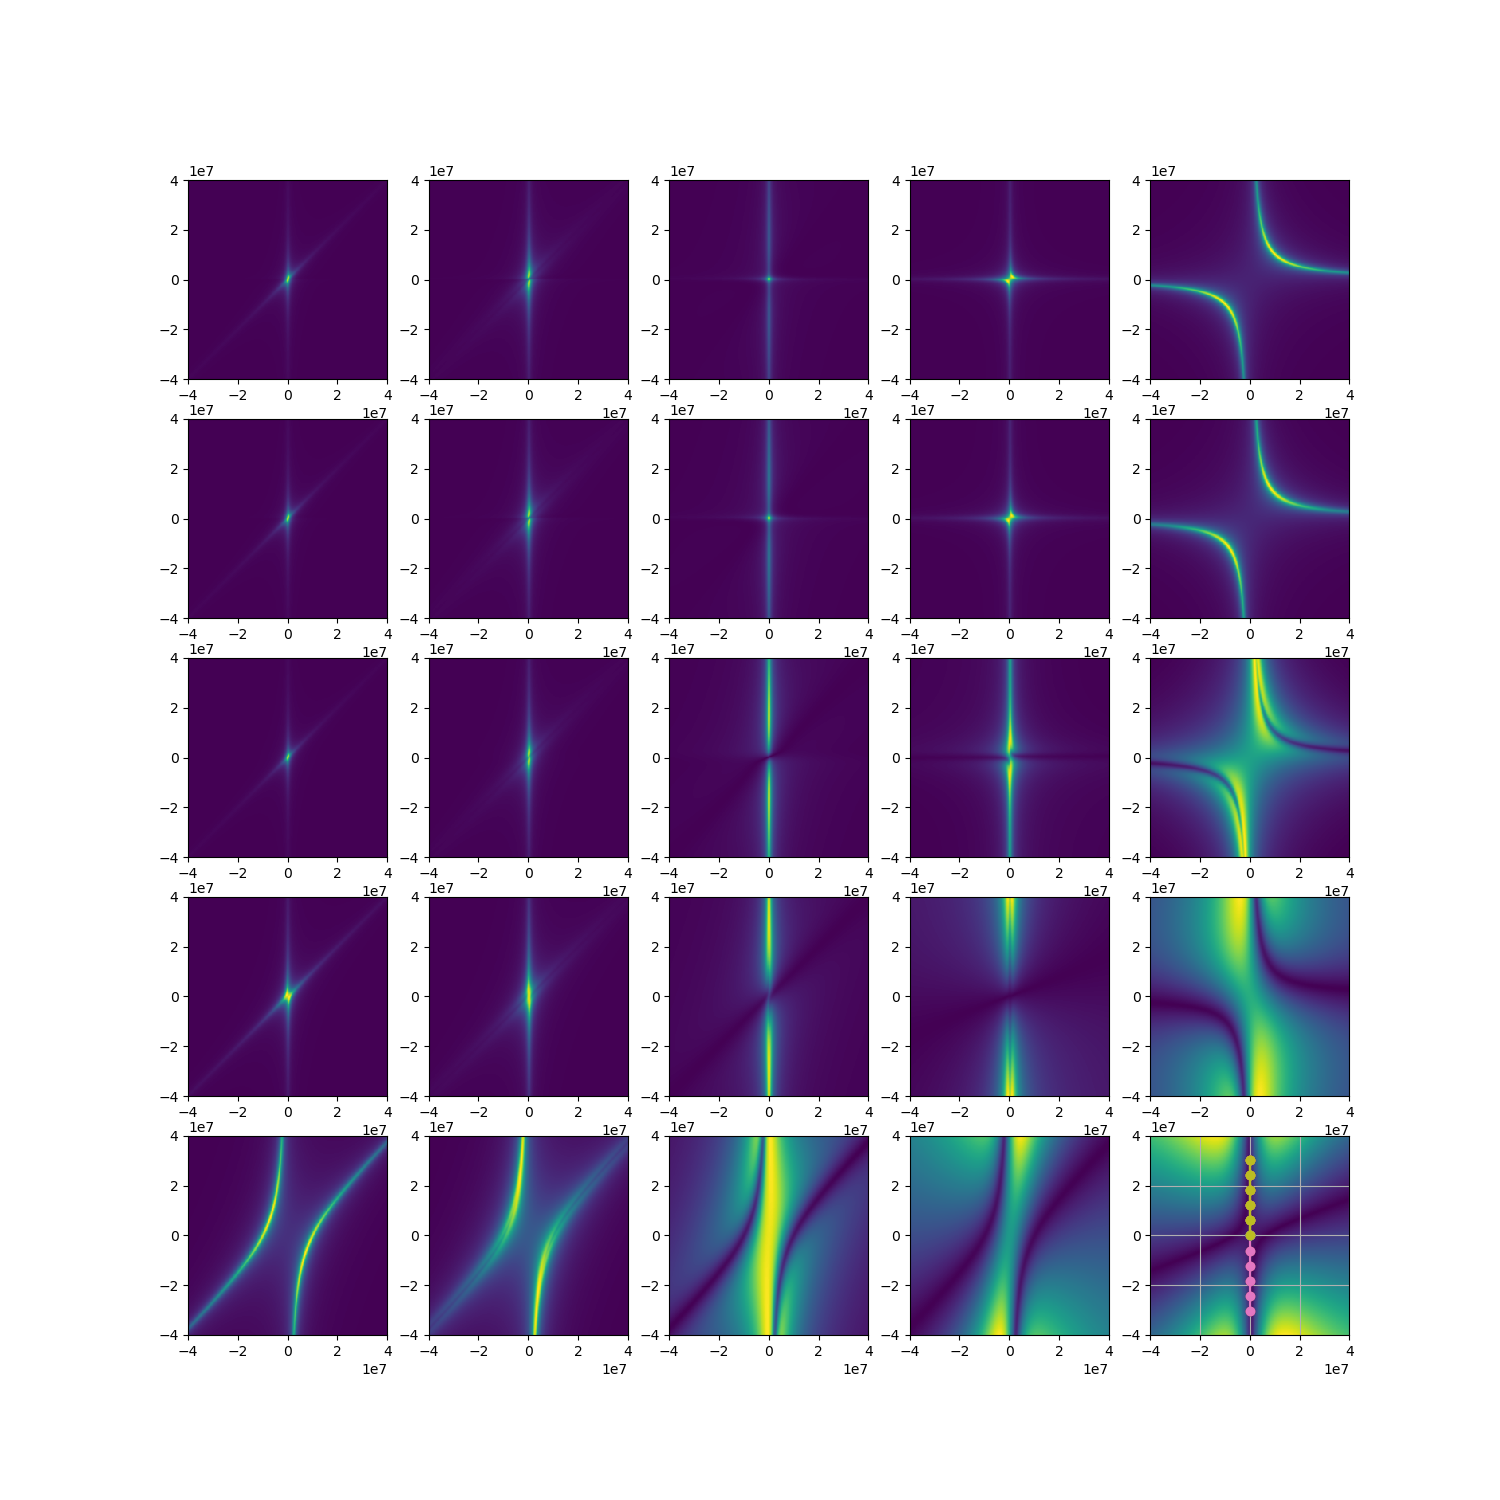

In [34]:
fig=plt.subplots(figsize=(15,15))
plt.rc('text', usetex=False)
pltnum=1
for ii in range(len(omegamvals_test)):
    for jj in range(len(omegaovals_test)):
        sbplt=plt.subplot(len(omegamvals_test), len(omegaovals_test),pltnum)
        pltnum+=1
        sbplt.imshow(np.abs(rho_save[ii,jj,:,:,0,2]),origin='lower',extent=im_lims)


<IPython.core.display.Javascript object>


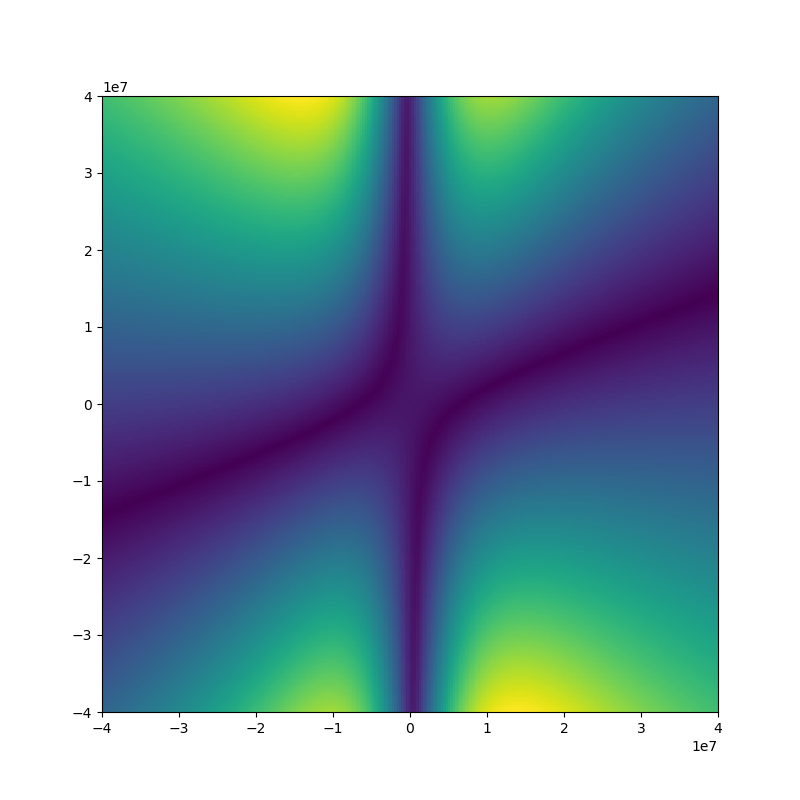

In [47]:
plt.rcParams['figure.figsize'] = [8, 8]


plt.imshow(np.abs(steady_rho_lots_of_args_inds(1,3,delta2vals,delta3vals,0,p)),origin='lower',extent=im_lims)

In [34]:
def a_func(del2_lims,del3_lims,*peak_fun):
    if len(peak_fun)!=0:
        S13=N*gval*rho13_integrated(del2_lims, del3_lims,peak_fun[0])
    else:
        S13=N*gval*rho13_integrated_quad(del2_lims,del3_lims)
    return -1j*deltac*aval-1j*S13-kappa/2*aval

In [35]:
p

{'a': 0,
 'delta2': 0.0,
 'delta3': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 20,
 'gammamu': 47.61904761904761,
 'g': 51.9,
 'N': 1280000000000000.0,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'df': 100000.0,
 'mean_delta2': 0,
 'sd_delta2': 66700480.96793615,
 'mean_delta3': 0,
 'sd_delta3': 453563270.5819659,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nmu': 2.22e+16,
 'gmu': 1.04,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqm': 5186000000.0,
 'freqo': 195113360000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'omegao': -492090.88755145477,
 'omegam': -4754308.429163911}

In [36]:
def dadt(del2_lims, del3_lims,aval,p,*peak_fun):
    kappa=p['kappaoi']+p['kappaoc']
    if len(peak_fun)!=0:
        S13=p['N']*p['g']*rho13_integrated(del2_lims, del3_lims,aval,p,peak_fun[0])[0]
    else:
        S13=p['N']*p['g']*rho13_integrated_quad(del2_lims,del3_lims,aval,p)
    return -1j*p['deltac']*aval-1j*S13-kappa/2*aval
    
def dadt_for_root(del2_lims, del3_lims,avec,p,*peak_fun):
    aval = avec[0]+1j*avec[1]
    # print(a)
    f = dadt(del2_lims, del3_lims,aval,p,*peak_fun)
    return [f.real,f.imag]

In [37]:
p['deltac']=1
p['kappaoi']=2*pi*1
p['kappaoc']=2*pi*1
p['g']=1000
p['N']=0

In [38]:
dadt([-40e6,40e6],[-40e6,40e6],1,p,delta3_mu_func)

(-6.283185307179586-1j)

In [39]:
dadt([-40e6,40e6],[-40e6,40e6],100,p)

(-3032496387.975302+15818965267.1267j)

In [39]:
kappa=p['kappaoi']+p['kappaoc']
kappa

In [40]:
rho13_integrated([-40e6,40e6],[-40e6,40e6],1,p,delta3_mu_func)[0]

(-2.2160171190860395e-06+6.539033542526499e-11j)

In [254]:
p

{'a': 0,
 'delta2': 0.0,
 'delta3': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 20,
 'gammamu': 47.61904761904761,
 'g': 46420771.21289563,
 'N': 1600.0000000000002,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'df': 100000.0,
 'mean_delta2': 0,
 'sd_delta2': 66700480.96793615,
 'mean_delta3': 0,
 'sd_delta3': 453563270.5819659,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nmu': 2.22e+16,
 'gmu': 1.04,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqm': 5186000000.0,
 'freqo': 195113360000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'omegao': -492090.88755145477,
 'omegam': -13399461.726722285}

In [41]:
def steadya(aguess,del2_lims,del3_lims,p,*peak_fun):
    aguess_vec=[aguess.real, aguess.imag]
    if len(peak_fun)!=0:
        a_steady_func=lambda aa : (dadt_for_root(del2_lims,del3_lims,aa,p,peak_fun[0]))
    else:
        a_steady_func=lambda aa : (dadt_for_root(del2_lims,del3_lims,aa,p))        
    result=scipy.optimize.root(a_steady_func,aguess_vec)
    if not result.success:
        print(result)
        raise(AssertionError('Git gud at converging, scrub: '+result.message))    
    a_steady=result.x[0]+1j*result.x[1]
    return a_steady

In [42]:
a_test=np.linspace(-1,1,11)
da_test=np.zeros(len(a_test),dtype=np.complex_)
for ii,a_test_val in enumerate(a_test):
    da_test[ii]=dadt([-np.inf,np.inf],[-np.inf,np.inf],a_test_val,p,delta3_mu_func)

In [43]:
da_test

array([ 6.28318531+1.j ,  5.02654825+0.8j,  3.76991118+0.6j,
        2.51327412+0.4j,  1.25663706+0.2j,  0.        +0.j ,
       -1.25663706-0.2j, -2.51327412-0.4j, -3.76991118-0.6j,
       -5.02654825-0.8j, -6.28318531-1.j ])

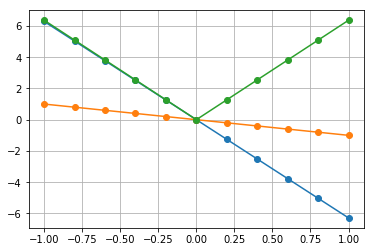

In [44]:
#plt.rcParams['figure.figsize'] = [18, 18]
plt.plot(a_test,np.real(da_test),'-o')
plt.plot(a_test,np.imag(da_test),'-o')
plt.plot(a_test,np.abs(da_test),'-o')

plt.grid()

In [49]:
plt.plot([1,2,3],[4,5,3])

In [45]:
# calculate microwave rabi frequency from power in in dBm
def omegam_from_Pin(Pin,p):
    mu0 = 4*pi*1e-7
    hbar=1.05457e-34; # in J*s
    Vsample=pi*((p['dsample']/2)**2) * p['Lsample'] # the volume of the Er:YSO sample
    V_microwave_cavity = Vsample/p['fillfactor']    
    mwP = 1e-3 * 10**(Pin/10)  #convert from dBm to Watts
    Q=2*pi*p['freqm']/(p['kappami']+p['kappamc']*2) # Q factor
    S21=(4*p['kappamc']**2)/(p['kappami']+p['kappamc']*2)**2
    energy_in_cavity=math.sqrt(S21)*2/(2*pi*p['freqm']/Q)*mwP; # energy inside the microwave cavity, in J
    Bmw=math.sqrt(mu0*(energy_in_cavity/V_microwave_cavity)/2); # Magnetic field of the microwave
    p['omegam']=(p['mu12']*Bmw)/hbar*(-1); # in rad/sec???? in Hz
    return p['omegam']

In [46]:
# calculate optical rabi frequency from power in in dBm
def omegao_from_Pin(Pin,p):
    epsilon0=8.854187817e-12
    hbar=1.05457e-34; # in J*s

    optP = 1e-3 * 10**(Pin/10) #incident optical power in W
    pflux = optP/(2*pi*p['freqo']*hbar) #photon flux (photons/sec)
    n_in = pflux * p['kappaoc']*4/(p['kappaoc']+p['kappaoi'])**2 # num intracavity photons
                                                #is this right????
    Sspot = pi*p['Wcavity']**2 #cross sectional area of
                                #optical mode
    V_cav = (Sspot*p['Lcavity_vac']+Sspot*p['Lsample']*p['nYSO']**3)/2;
    optEfield = math.sqrt(n_in*hbar*2*pi*p['freqo']/2/epsilon0/V_cav);
    p['omegao'] = p['d23']*optEfield/hbar*(-1);
    return p['omegao']

In [47]:
p = {}
p['a'] = 0
aval=p['a']
p['delta2'] = 0.
p['delta3'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['g'] = 51.9  #optical coupling
p['N'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for 
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
p['df']=0.1e6 # how small descretisation step to take when integrating over the 
            # inhomogeneous lines

p['mean_delta2']=0
p['sd_delta2']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delta3']=0
p['sd_delta3']=2*pi*170e6/2.355 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nmu'] = 2.22e16  #toal number of atoms
p['gmu'] = 1.04 #coupling between atoms and microwave field


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqm'] = 5.186e9
p['freqo'] = 195113.36e9

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76 #refractive index of YSO

# assume 1mW (=0dBm) input to both optical and to microwave cavities
omegao_from_Pin(0,p)
omegam_from_Pin(0,p)

#see what rabi freqs we have
#p['omegao']/1e6,p['omegam']/1e6


In [48]:
p

{'a': 0,
 'delta2': 0.0,
 'delta3': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 20,
 'gammamu': 47.61904761904761,
 'g': 51.9,
 'N': 1280000000000000.0,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'df': 100000.0,
 'mean_delta2': 0,
 'sd_delta2': 66700480.96793615,
 'mean_delta3': 0,
 'sd_delta3': 453563270.5819659,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nmu': 2.22e+16,
 'gmu': 1.04,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqm': 5186000000.0,
 'freqo': 195113360000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'omegao': -492090.88755145477,
 'omegam': -4754308.429163911}

In [58]:
alpha = math.sqrt(p['N'])/40
p['g'] = alpha *p['g']
p['N'] = p['N']/alpha**2

#this parameter shouldn't change
math.sqrt(p['N'])*p['g']/1e9, " GHz"

Pmu_vals_dBm = np.arange(-30,10,3) # in dBm
Pmu_vals_W = 1e-3*np.exp(np.log(10)*Pmu_vals_dBm/10) #in W

avals_approx = np.zeros(Pmu_vals_dBm.shape,dtype='complex128')
avals = np.zeros(Pmu_vals_dBm.shape,dtype='complex128')
davals = np.zeros(Pmu_vals_dBm.shape,dtype='complex128')

for (i,P) in enumerate(Pmu_vals_dBm):
    #print("%d/%d"%(i+1,len(Pmu_vals_dBm)),end="")
    omegam_from_Pin(P,p)
    avals[i] = steadya(0+1j*0,[-np.inf,np.inf],[-np.inf,np.inf],p)*alpha
    davals[i] = dadt([-np.inf,np.inf],[-np.inf,np.inf],avals[i],p)
    #print(" -- completed")


In [60]:
davals

array([ 0.00000000e+00+0.00000000e+00j, -6.51056430e-43+0.00000000e+00j,
        0.00000000e+00-2.16840434e-19j, -1.66847464e-43+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  1.71056941e-49+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+5.42101086e-20j,
       -3.34095589e-52+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        2.61012179e-54-8.47032947e-22j,  1.71038456e-49+0.00000000e+00j])

<IPython.core.display.Javascript object>


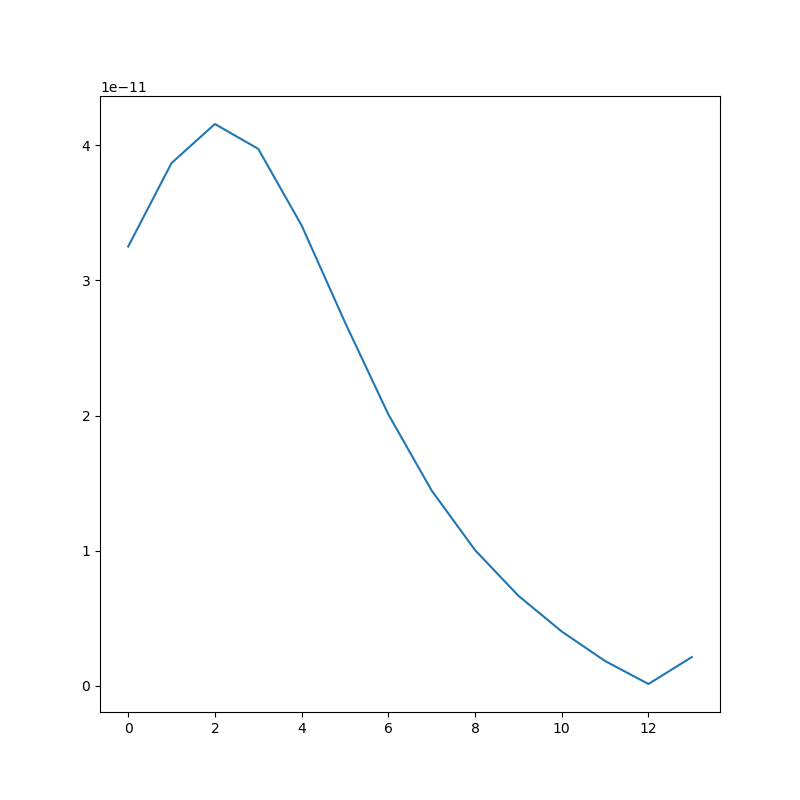

In [61]:
plt.plot(abs(avals))

In [247]:
plz=steadya(1+1j*1.1,[-np.inf,np.inf],[-np.inf,np.inf],p)

In [248]:
plz

(1.7039232114316837e-33-7.91838080899259e-11j)

In [249]:
# this is the energy efficiency of the conversion
effic = p['kappaoc']*np.abs(avals**2)*const.h*p['freqo'] /Pmu_vals_W

# quantum efficiency
effic  = effic*p['freqm']/p['freqo']


In [259]:
%matplotlib notebook

<IPython.core.display.Javascript object>


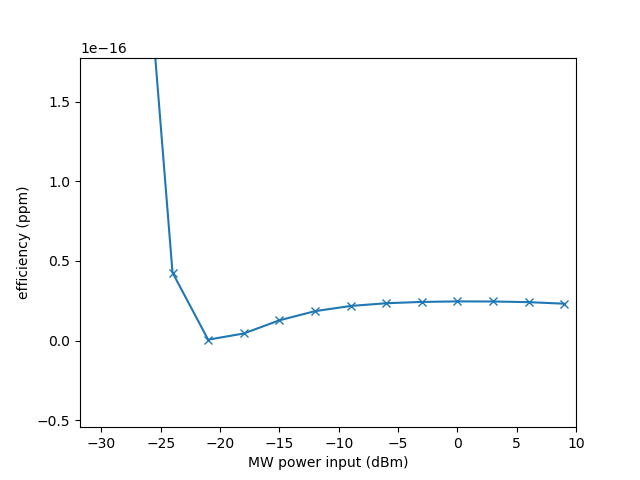

In [261]:
plt.plot(Pmu_vals_dBm,effic*1e6,'x-')
plt.ylabel('efficiency (ppm)')
plt.xlabel('MW power input (dBm)');

In [131]:





p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./.1e-6 #unrealistically fast, but makes calculations easier
p['gamma3d'] = 1./.1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 60e6
p['omegam'] = 1e3
p['g'] = 0.

p['mean_delta2']=0
p['sd_delta2']=20e6
p['mean_delta3']=0
p['sd_delta3']=20e6 #not realistic but makes calculations faster

delta2vals = np.linspace(-100e6,100e6,101)
delta3vals = np.linspace(-1000e6,1000e6,1001)
coh13_vals = np.zeros((len(delta2vals),len(delta3vals)),dtype=np.complex_)
gauss_vals = np.zeros((len(delta2vals),len(delta3vals)),dtype=np.complex_)
coh13broad_vals = np.zeros((len(delta2vals),len(delta3vals)),dtype=np.complex_)

for ii, del2val in enumerate(delta2vals):
    for jj, del3val in enumerate(delta3vals):
        coh13_vals[ii,jj]=coh13_Rfun(del2val,del3val,0,p)+1.j*coh13_Ifun(del2val,del3val,0,p)
        coh13broad_vals[ii,jj]=coh13_Rguass_fun(del2val,del3val,0,p)+1.j*coh13_Iguass_fun(del2val,del3val,0,p)

        gauss_vals[ii,jj]=gauss_fun(del2val,del3val,p['mean_delta2'],p['mean_delta3'],p['sd_delta2'],p['sd_delta3'])



In [109]:
import scipy.signal

In [132]:
wtf=scipy.signal.fftconvolve(coh13_vals,gauss_vals)

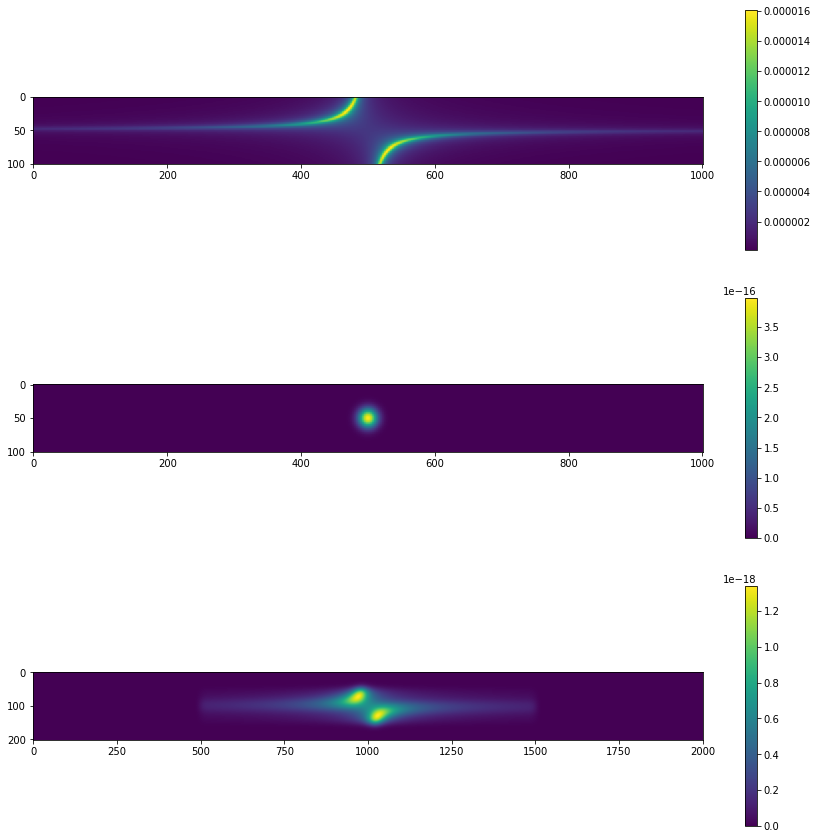

In [135]:
%matplotlib inline
fig=plt.subplots(figsize=(15,15))

plt.subplot(3,1,1)
plt.imshow(abs(coh13_vals))
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(gauss_vals.real)
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(abs(wtf))
plt.colorbar()


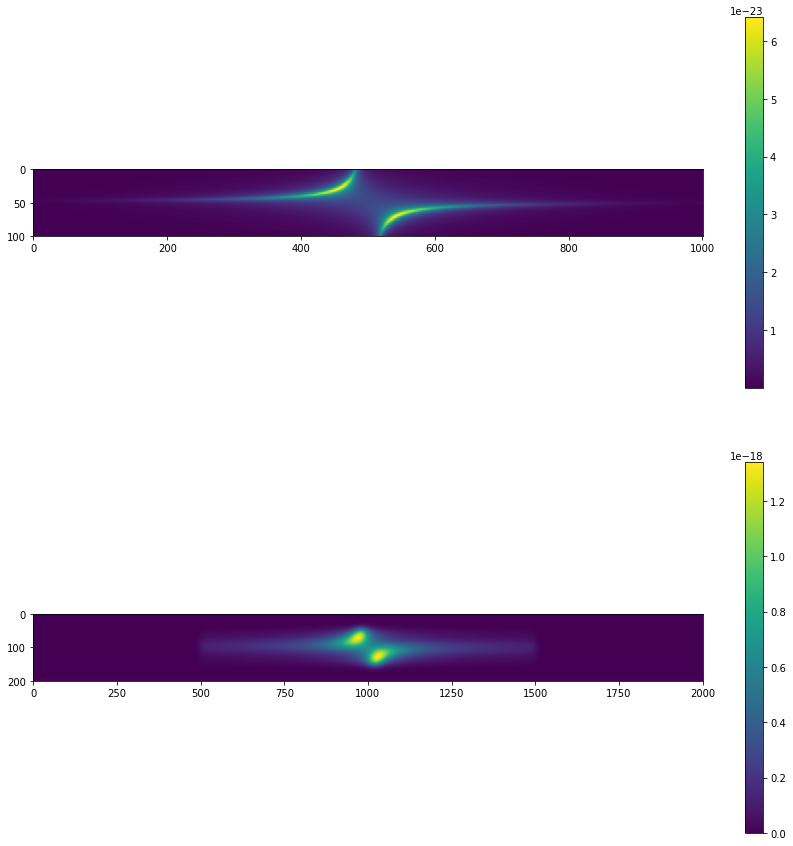

In [140]:
fig=plt.subplots(figsize=(15,15))

plt.subplot(2,1,1)
plt.imshow(abs( coh13broad_vals))
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(abs(wtf))
plt.colorbar()

In [153]:
# parameters from Stephen via slack
# parameters commented out are not used in calculation
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['g'] = 51.9  #optical coupling
p['N'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for 
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
p['df']=0.1e6 # how small descretisation step to take when integrating over the 
            # inhomogeneous lines

p['mean_delta2']=0
p['sd_delta2']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delta3']=0
p['sd_delta3']=2*pi*170e6/2.355 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nmu'] = 2.22e16  #toal number of atoms
p['gmu'] = 1.04 #coupling between atoms and microwave field


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqm'] = 5.186e9
p['freqo'] = 195113.36e9

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76 #refractive index of YSO

# assume 1mW (=0dBm) input to both optical and to microwave cavities
omegao_from_Pin(0,p)
omegam_from_Pin(0,p)

#see what rabi freqs we have
p['omegao']/1e6,p['omegam']/1e6


In [154]:
p

{'a': 0,
 'delta2': 0.0,
 'delta3': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 20,
 'gammamu': 47.61904761904761,
 'g': 51.9,
 'N': 1280000000000000.0,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'df': 100000.0,
 'mean_delta2': 0,
 'sd_delta2': 66700480.96793615,
 'mean_delta3': 0,
 'sd_delta3': 453563270.5819659,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nmu': 2.22e+16,
 'gmu': 1.04,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqm': 5186000000.0,
 'freqo': 195113360000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'omegao': -492090.88755145477,
 'omegam': -4754308.429163911}

In [155]:
alpha = math.sqrt(p['N'])/40
p['g'] = alpha *p['g']
p['N'] = p['N']/alpha**2

#this parameter shouldn't change
math.sqrt(p['N'])*p['g']/1e9, " GHz"

(1.8568308485158254, ' GHz')

In [150]:
alpha

In [49]:
del2_lims=[-3*p['sd_delta2']+p['mean_delta2'], 3*p['sd_delta2']+p['mean_delta2']]
del3_lims=[-3*p['sd_delta3']+p['mean_delta3'], 3*p['sd_delta3']+p['mean_delta3']]

test_int=rho13_integrated_quad(del2_lims,del3_lims,0,p)

In [146]:
test_int

(-1.954932454318499e-05+0j)

In [151]:
steadya(0,del2_lims,del3_lims,p)*alpha

(-7.388669858906419e-06+17521.76678525617j)

In [179]:
# parameters from Stephen via slack
# parameters commented out are not used in calculation
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['g'] = 51.9  #optical coupling
p['N'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for 
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
p['df']=0.1e6 # how small descretisation step to take when integrating over the 
            # inhomogeneous lines

p['mean_delta2']=0
p['sd_delta2']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delta3']=0
p['sd_delta3']=2*pi*170e6/2.355 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nmu'] = 2.22e16  #toal number of atoms
p['gmu'] = 1.04 #coupling between atoms and microwave field


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqm'] = 5.186e9
p['freqo'] = 195113.36e9

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76 #refractive index of YSO

# assume 1mW (=0dBm) input to both optical and to microwave cavities
omegao_from_Pin(0,p)
omegam_from_Pin(0,p)

#see what rabi freqs we have
p['omegao']/1e6,p['omegam']/1e6
alpha = math.sqrt(p['N'])/40
p['g'] = alpha *p['g']
p['N'] = p['N']/alpha**2

#this parameter shouldn't change
math.sqrt(p['N'])*p['g']/1e9, " GHz"
del2_lims=[-3*p['sd_delta2']+p['mean_delta2'], 3*p['sd_delta2']+p['mean_delta2']]
del3_lims=[-3*p['sd_delta3']+p['mean_delta3'], 3*p['sd_delta3']+p['mean_delta3']]

In [157]:
dadt(del2_lims,del3_lims,0,p)

1451991.5551773375j

In [158]:
p

{'a': 0,
 'delta2': 0.0,
 'delta3': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 20,
 'gammamu': 47.61904761904761,
 'g': 46420771.21289563,
 'N': 1600.0000000000002,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'df': 100000.0,
 'mean_delta2': 0,
 'sd_delta2': 66700480.96793615,
 'mean_delta3': 0,
 'sd_delta3': 453563270.5819659,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nmu': 2.22e+16,
 'gmu': 1.04,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqm': 5186000000.0,
 'freqo': 195113360000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'omegao': -492090.88755145477,
 'omegam': -4754308.429163911}

In [160]:
kappa=p['kappaoi']+p['kappaoc']
  
S13=p['N']*p['g']*rho13_integrated_quad(del2_lims,del3_lims,aval,p)
test_ans=-1j*p['deltac']*aval-1j*S13-kappa/2*aval

In [161]:
test_ans

1451991.5551773375j

In [166]:
dadt_for_root(del2_lims,del3_lims,[1,1],p)

In [168]:
steadya(0,del2_lims,del3_lims,p)

(-8.260784033909267e-12+0.01958993080886538j)

In [175]:
a_test=1j*np.linspace(0,0.1,200)+-8.260784033909267e-12
da_test=np.zeros(len(a_test),dtype=np.complex_)
for ii, a_test_val in enumerate(a_test):
    da_test[ii]=dadt(del2_lims,del3_lims,a_test_val,p)

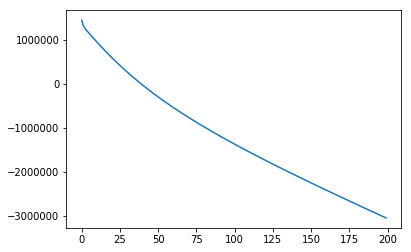

In [178]:
plt.plot(np.imag(da_test))

In [182]:


Pmu_vals_dBm = np.arange(-30,10,3) # in dBm
Pmu_vals_W = 1e-3*np.exp(np.log(10)*Pmu_vals_dBm/10) #in W

avals_approx = np.zeros(Pmu_vals_dBm.shape,dtype='complex128')
avals = np.zeros(Pmu_vals_dBm.shape,dtype='complex128')

for (i,P) in enumerate(Pmu_vals_dBm):
    #print("%d/%d"%(i+1,len(Pmu_vals_dBm)),end="")
    omegam_from_Pin(P,p)
    avals[i] = steadya(avals[i-1],del2_lims,del3_lims,p)*alpha

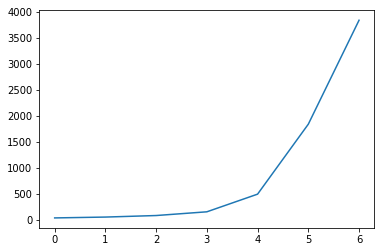

In [196]:
plt.plot(abs(avals[0:7]))

In [190]:
effic = p['kappaoc']*np.abs(avals**2)*const.h*p['freqo'] /Pmu_vals_W
effic  = effic*p['freqm']/p['freqo']


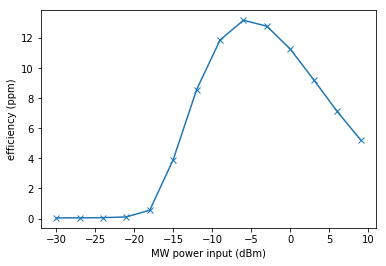

In [191]:
plt.plot(Pmu_vals_dBm,effic*1e6,'x-')
plt.ylabel('efficiency (ppm)')
plt.xlabel('MW power input (dBm)');

In [192]:
avals

array([ 1.33652340e-14+3.26604400e+01j, -9.28089725e-13+4.89256555e+01j,
        5.85030910e-10+7.85820282e+01j, -4.57768211e-13+1.50271156e+02j,
       -1.01839939e-13+4.90404325e+02j,  2.36722297e-11+1.83762057e+03j,
        1.40457532e-11+3.83941744e+03j, -5.63118081e-07+6.38180813e+03j,
       -2.41873202e-05+9.50019671e+03j,  2.93706284e-07+1.32151287e+04j,
        4.24306788e-10+1.75217668e+04j, -8.42935448e-08+2.23988100e+04j,
        5.98502837e-10+2.78029909e+04j,  7.92509833e-10+3.36630970e+04j])

In [201]:
def steadya_fsolve(aguess,del2_lims,del3_lims,p,*peak_fun):
    aguess_vec=[aguess.real, aguess.imag]
    if len(peak_fun)!=0:
        a_steady_func=lambda aa : (dadt_for_root(del2_lims,del3_lims,aa,p,peak_fun[0]))
    else:
        a_steady_func=lambda aa : (dadt_for_root(del2_lims,del3_lims,aa,p))        
    result=scipy.optimize.fsolve(a_steady_func,aguess_vec)
    #if not result.success:
    #    print(result)
    #    raise(AssertionError('Git gud at converging, scrub: '+result.message))    
    a_steady=result[0]+1j*result[1]
    return a_steady

In [202]:


Pmu_vals_dBm = np.arange(-30,10,3) # in dBm
Pmu_vals_W = 1e-3*np.exp(np.log(10)*Pmu_vals_dBm/10) #in W

avals_approx = np.zeros(Pmu_vals_dBm.shape,dtype='complex128')
avals_f = np.zeros(Pmu_vals_dBm.shape,dtype='complex128')

for (i,P) in enumerate(Pmu_vals_dBm):
    #print("%d/%d"%(i+1,len(Pmu_vals_dBm)),end="")
    omegam_from_Pin(P,p)
    avals_f[i] = steadya_fsolve(avals[i-1],del2_lims,del3_lims,p)*alpha

/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


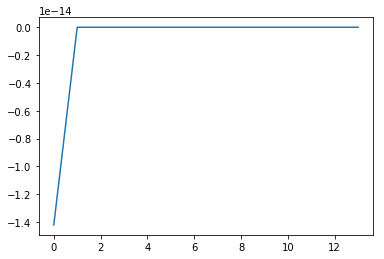

In [206]:
plt.plot(avals_f.imag-avals.imag)

In [208]:
aa, bb= (1,2)

In [227]:
dadt_fun=lambda t, aa : dadt(del2_lims,del3_lims,aa[0],p)
test_fun=lambda t, y : 0.5*y

In [230]:
tspan =[0,10]
y0=1+1j
sol=scipy.integrate.solve_ivp(dadt_fun,tspan,[y0,0+1j*0])

KeyboardInterrupt: 

In [158]:
delta2vals=np.linspace(del2_lims[0],del2_lims[1],250)
delta3vals=np.linspace(del3_lims[0],del3_lims[1],2500)*0.1
delta2vals=np.linspace(-40e6,40e6,2501)
delta3vals=np.linspace(-40e6,40e6,2501)


In [160]:
coh13_test1=steady_rho_lots_of_args_inds(1,3,delta2vals,delta3vals,0,p)

In [161]:
delta3_o_func2=lambda del3 : p['omegao']**2/del3 if del3!=0 else np.nan
def delta3_o_func2(delta3vals):
    del2out=np.zeros(np.size(delta3vals))
    for ii, del3val in enumerate(delta3vals):
        if del3val!=0:
            del2out[ii]=p['omegao']**2/del3val
        else:
            del2out[ii]=np.nan
    return del2out

def delta3_mu_func2(delta3vals):
    del2out=np.zeros(np.size(delta3vals))
    for ii, del3val in enumerate(delta3vals):
        del2out[ii]=delta3_mu_func(del3val)
    return del2out

In [162]:
ds_test1=dressed_states(delta3vals,p)

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/peter/anaconda3/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """
/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


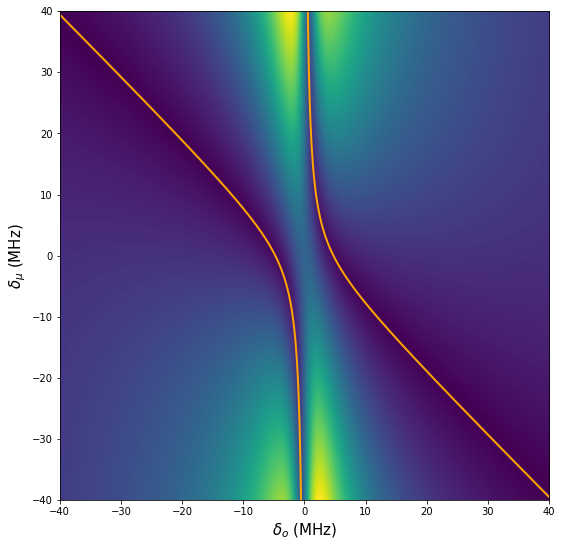

In [163]:
fig,ax=plt.subplots(1,1,figsize=(9,9))
del2_ds1=delta3_mu_func2(delta3vals)
#ax.imshow(abs(coh13_test1),extent=[min(delta3vals),max(delta3vals),min(delta2vals),max(delta2vals)])
ax.plot(np.array(delta3vals)*1e-6,-np.array(del2_ds1)*1e-6,color='orange',linewidth=2)
#ax.plot(delta3vals,-ds_test1)

ax.imshow(abs(coh13_test1),extent=np.array([min(delta3vals),max(delta3vals),min(delta2vals),max(delta2vals)])*1e-6)

fig.set_figwidth(9)
fig.set_figheight(9)

ax.set_xlabel('$\delta_o$ (MHz)', fontsize=15)
ax.set_ylabel('$\delta_\mu$ (MHz)',fontsize=15)
ax.imshow(abs(coh13_test1),extent=np.array([min(delta3vals),max(delta3vals),min(delta2vals),max(delta2vals)])*1e-6)


NameError: name 'L' is not defined